In [16]:
# Initial imports
from pathlib import Path
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# # Keras modules
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense



In [17]:
df = pd.read_csv(Path('runner_result_runner_result.csv'))
df = df.drop(columns="Unnamed: 0")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13188 entries, 0 to 13187
Data columns (total 89 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   meetingName                      13188 non-null  object 
 1   meetingDate                      13188 non-null  object 
 2   raceNumber                       13188 non-null  int64  
 3   runnerNumber                     13188 non-null  int64  
 4   location                         0 non-null      float64
 5   weatherCondition                 13022 non-null  object 
 6   trackCondition                   13022 non-null  object 
 7   raceName                         13188 non-null  object 
 8   raceStartTime                    13188 non-null  object 
 9   raceDistance                     13188 non-null  int64  
 10  trackDirection                   0 non-null      float64
 11  raceClassConditions              13188 non-null  object 
 12  runnerName        

In [18]:
runner_starts_df = df.iloc[:, 17:31]
runner_wins_df = df.iloc[:,31:45]
runner_placings_df = df.iloc[:,45:59]
trainer_starts_df = df.iloc[:,59:64]
trainer_wins_df = df.iloc[:,64:69]
trainer_placings_df = df.iloc[:,69:74]
rider_starts_df = df.iloc[:,74:79]
rider_wins_df = df.iloc[:,79:84]
rider_placings_df = df.iloc[:,84:]
fixed_wins_df = df.iloc[:,15:17] 

runners_df = pd.concat([runner_starts_df,runner_wins_df,runner_placings_df],axis=1,join='inner')
trainer_df = pd.concat([trainer_starts_df,trainer_wins_df,trainer_placings_df],axis=1,join='inner')
rider_df = pd.concat([rider_starts_df,rider_wins_df,rider_placings_df],axis=1,join='inner') 

df = df.iloc[:,0:15]


In [19]:
df['finishingPosition'] = df['finishingPosition'].apply( lambda x: x if x>=1 and x<=3 else 0 )
df.finishingPosition.value_counts()
# df

0.0    10435
1.0      919
3.0      917
2.0      917
Name: finishingPosition, dtype: int64

In [20]:
# Convert categorical features to numerical
weatherCondition_df = pd.get_dummies(df.weatherCondition)
trackCondition_df = pd.get_dummies(df.trackCondition)
raceClassConditions_df = pd.get_dummies(df.raceClassConditions)
# raceName = pd.get_dummies(df.raceName)
# meetingName = pd.get_dummies(df.meetingName)

In [21]:
# df = pd.concat([weatherCondition,trackCondition,raceClassConditions,raceName,meetingName,df],axis=1)
# df = pd.concat([df,weatherCondition,trackCondition,raceClassConditions],axis=1)
# df

In [22]:
y = df.finishingPosition
y

0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
13183    2.0
13184    0.0
13185    0.0
13186    1.0
13187    0.0
Name: finishingPosition, Length: 13188, dtype: float64

In [23]:
df = df.drop(columns=['weatherCondition','trackCondition','location','trackDirection','runnerName','riderName'])
df = df.drop(columns=['meetingDate','raceStartTime','raceClassConditions','raceName','meetingName'])
X = df.drop(columns='finishingPosition')
X = X.drop(columns=['raceNumber','runnerNumber'])

X

,raceNumber,runnerNumber,raceDistance,finishingPosition
0,1,3,1100,0.0
1,1,11,1100,0.0
2,1,2,1100,0.0
3,1,9,1100,0.0
4,1,8,1100,1.0
...,...,...,...,...
13183,8,5,1300,2.0
13184,8,4,1300,0.0
13185,8,7,1300,0.0
13186,8,6,1300,1.0


In [24]:
def deep_net(X,y,include_dfs,epochs,no_hidden_nodes,no_layers):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    import matplotlib.pyplot as plt
    
    if len(include) > 0:
        for data_frame in include_dfs:
            X = pd.concat([X, data_frame],axis=1,join='inner')

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    X_scaler = StandardScaler()
    X_scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
  
    neuron = Sequential()
    
    number_inputs = len(X_test_scaled[0])
    number_hidden_nodes = no_hidden_nodes
    neuron.add(Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))
    
    count = 0;
    while count < no_layers:
        neuron.add(Dense(units=number_hidden_nodes, activation="relu"))
        count = count + 1

    neuron.add(Dense(units=1, activation="linear"))

    neuron.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
    # neuron.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])    

    model = neuron.fit(X_train_scaled, y_train, validation_split=0.3, epochs=epochs)#,verbose=0) 
    
    # importances = model.feature_importances_
    
    # Evaluate the model using testing data
    model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


    plt.plot(model.history["loss"])
    plt.plot(model.history["val_loss"])
    plt.title(f"loss_function - Training Vs. Validation - {no_layers} hidden layers")
    plt.legend(["train", "test"])
    plt.show()
    
    return model;
    


Epoch 1/10
217/217 [==============================] - 2s 4ms/step - loss: 0.8581 - accuracy: 0.7872 - val_loss: 0.8223 - val_accuracy: 0.7719
Epoch 2/10
217/217 [==============================] - 1s 3ms/step - loss: 0.8053 - accuracy: 0.7588 - val_loss: 0.8064 - val_accuracy: 0.7871
Epoch 3/10
217/217 [==============================] - 1s 3ms/step - loss: 0.7961 - accuracy: 0.7913 - val_loss: 0.8015 - val_accuracy: 0.7864
Epoch 4/10
217/217 [==============================] - 1s 3ms/step - loss: 0.7932 - accuracy: 0.7885 - val_loss: 0.8002 - val_accuracy: 0.7800
Epoch 5/10
217/217 [==============================] - 1s 3ms/step - loss: 0.7926 - accuracy: 0.7841 - val_loss: 0.7998 - val_accuracy: 0.7759
Epoch 6/10
217/217 [==============================] - 1s 3ms/step - loss: 0.7927 - accuracy: 0.7832 - val_loss: 0.8002 - val_accuracy: 0.7766
Epoch 7/10
217/217 [==============================] - 1s 3ms/step - loss: 0.7928 - accuracy: 0.7822 - val_loss: 0.7996 - val_accuracy: 0.7732
Epoch 

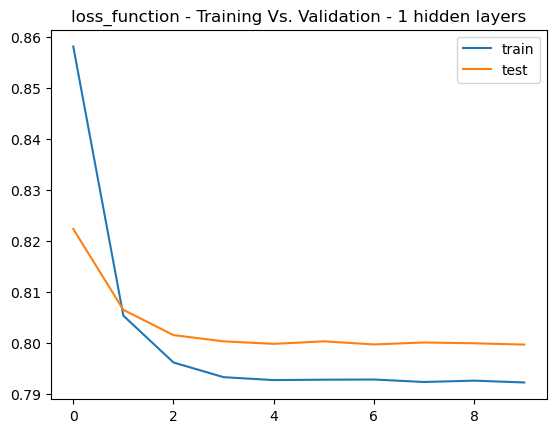

In [36]:
# runners_df = pd.concat([runner_starts_df,runner_wins_df,runner_placings_df],axis=1,join='inner')
# runner_starts_df
# runner_wins_df
# runner_placings_df

# trainer_df = pd.concat([trainer_starts_df,trainer_wins_df,trainer_placings_df],axis=1,join='inner')
# trainer_starts_df
# trainer_wins_df
# trainer_placings_df

# rider_df = pd.concat([rider_starts_df,rider_wins_df,rider_placings_df],axis=1,join='inner') 
# rider_starts_df
# rider_wins_df
# rider_placings_df

# fixed_wins_df
# df = df.iloc[:,0:15]

# weatherCondition_df
# trackCondition_df
# trackCondition_df

include = [weatherCondition_df,trackCondition_df,trackCondition_df]
no_layers = 1
epochs = 10#50
hidden_nodes = 5#10
model = deep_net(X,y,include,epochs,hidden_nodes,no_layers)


In [26]:
    # Create a DataFrame with the history dictionary
    eval_df = pd.DataFrame( model.history, index=range(1, len(model.history["loss"]) + 1))
    
    # Plot the loss
    # eval_df.plot(y="loss")
    # eval_df
    
    type(model)

keras.src.callbacks.History